---------------
The two methods for triangulation produce similar results.
Comparing the results with different amounts of roundup shows how similar they are.
Total quantity of numbers in triangulation data 1155
Not Rounded - quantity of not-matching numbers 942 , 81.6 %
Rounded to 5 decimals - quantity of not-matching numbers 1042 , 90.2 %
Rounded to 4 decimals - quantity of not-matching numbers 1038 , 89.9 %
Rounded to 3 decimals - quantity of not-matching numbers 986 , 85.4 %
Rounded to 2 decimals - quantity of not-matching numbers 660 , 57.1 %
Rounded to 1 decimals - quantity of not-matching numbers 127 , 11.0 %
Rounded to 0 decimals - quantity of not-matching numbers 0 , 0.0 %
---------------


<IPython.core.display.Javascript object>


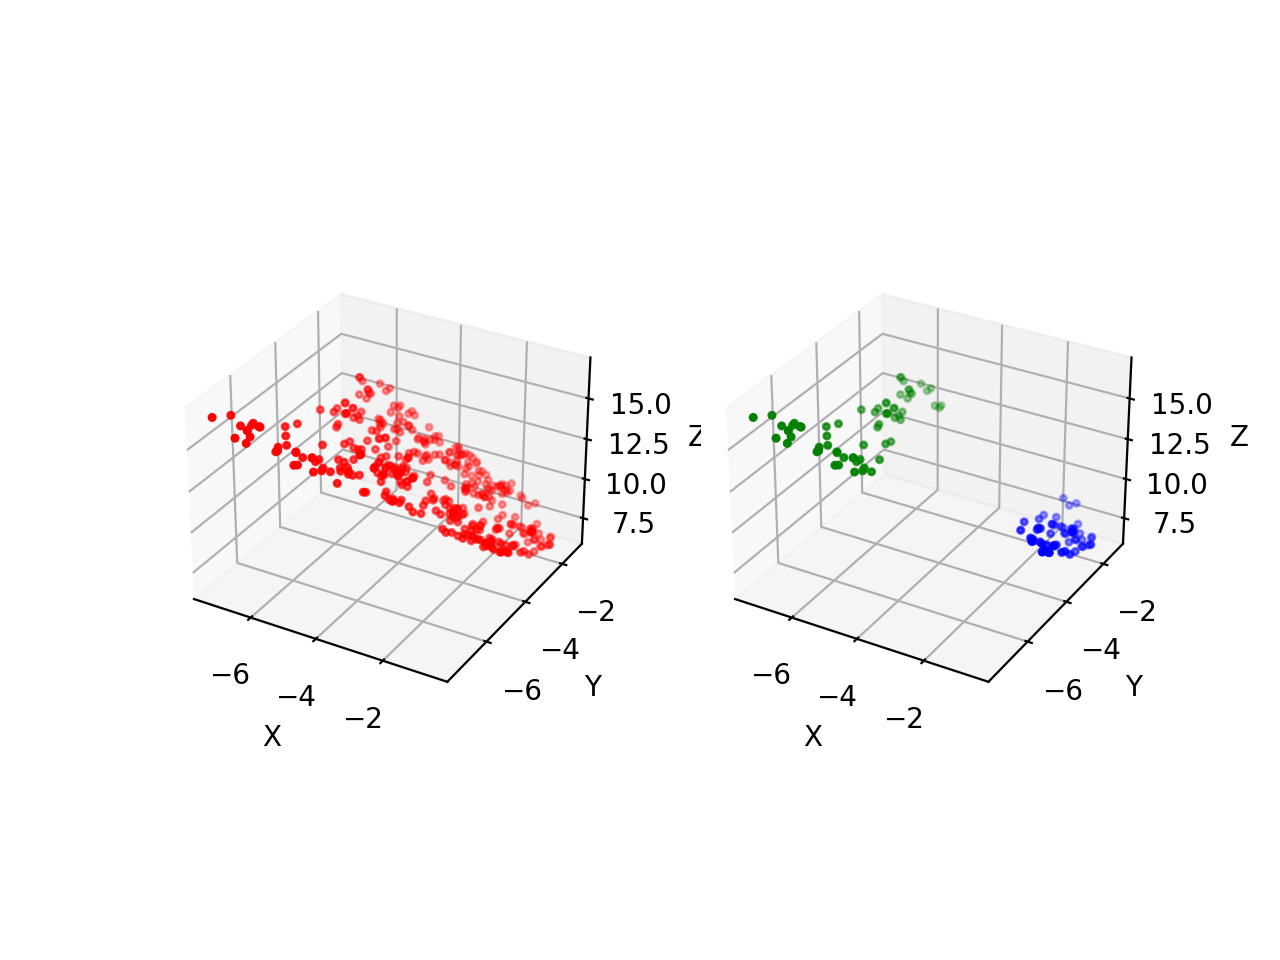

scikit-image version: 0.20.0
scipy version: 1.11.3
OpenCV version: 4.8.0
np version: 1.24.3
matplotlib version: 3.7.2
done
Python version
3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]


In [9]:
import cv2
import numpy as np 
from glob import glob
from mpl_toolkits.mplot3d import axes3d, Axes3D
#from skimage.measure import ransac
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.transform import FundamentalMatrixTransform
import matplotlib.pyplot as plt
%matplotlib notebook

"""
relationship between these matrices ...
instrinsic (K), the characteristics of the camera, 3x3
rotation (R), rotation of the camera between shots (Perform SVD of E to obtain R and T up to a scale.)!!
translation (T), the translation of the camera between shots
extrinsic = [R∣T]
fundamental (helps find corresponding points in a stereo pair), 3x3
essential (determined from K and F)(E = np.dot(K1.T,np.dot(F,K2)))
projection(P) = K⋅[R∣T]
"""

###########################################################
## Camera Calibration
###########################################################

"""
    determined K for my pixelb7a (cell phone) camera is ...
    
    [[1.07387531e+03 0.00000000e+00 4.87802829e+02]
    [0.00000000e+00 1.10279033e+03 5.51208199e+02]
    [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

    which is approximately
 
    1000,0,500
    0,1000,500
    0,0,1
    
    which when looking at parts of K 
    
    fx, s,  cx
    0,  fy, cy
    0,  0,  1
    
    means that ... 
    
    fx,fy ~= 1000,1000  (the focal lengths in the x and y directions)
    cx, cy ~= 500,500   (the coordinates of the principal point)
    s = 0  (skew factor, usually zero in well-calibrated cameras) 
"""
 
def get_camera_intrinsic_matrix(): 
    
    # based on programing assignment #4, in class unit/week #8  
     
    # using 8 column, 10 row checkerboard from
    # https://www.mrpt.org/downloads/camera-calibration-checker-board_9x7.pdf
    CHECKERBOARD = (7,9) 

    # world coordinates for 3D points
    objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32) 
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) 
    
    # load the pictures taken of that printout of checkerboard pdf mentioned above
    img1x = [cv2.imread(str(img)) for img in glob(str("calibration/*.dng"))] 
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 0.0001)
    objpoints1x, imgpoints1x = [], [] 

    for img in img1x:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(img, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        if ret == True:
            objpoints1x.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
            imgpoints1x.append(corners2)  
 
    # to obtain the intrinsic matrix K1, the two "None" terms in each line should remain.        
    _, K, _, _, _ = cv2.calibrateCamera(objpoints1x, imgpoints1x, img1x[0].shape[:-1][::-1], None, None) 
 
    return K
###########################################################
## Display
###########################################################
def display_2d_matches(image1, keypoints1, image2, keypoints2, good_matches): 
    
    if (isinstance(keypoints1, np.ndarray) and 
        isinstance(keypoints1[0], np.ndarray) and 
        isinstance(good_matches, np.ndarray) and
        isinstance(good_matches[0], np.ndarray)): 
            
        fig, ax = plt.subplots(nrows=1, ncols=1)
        plt.gray()
        plot_matches(ax,
                     image1,
                     image2,
                     keypoints1,
                     keypoints2,
                     good_matches,
                     only_matches=True)
        ax.axis("off")
        ax.set_title("Inlier correspondences")
        plt.show()
    
    elif (isinstance(keypoints1, tuple) and 
        isinstance(keypoints1[0], cv2.KeyPoint) and 
        isinstance(good_matches, list) and
        isinstance(good_matches[0], cv2.DMatch)): 
            
        # Draw the matches
        matching_result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # delineate two images, because they look so similar they visual blend
        start_point = (400, 0)  
        end_point = (400, 400)  
        color = (0, 0, 0)  
        thickness = 3 
        matching_result = cv2.line(matching_result, start_point, end_point, color, thickness) 

        # Display the result
        cv2.imshow('Matches', matching_result)
        cv2.waitKey(1000)
        cv2.destroyAllWindows() 



#from mpl_toolkits.mplot3d import Axes3D 

def display_3d_matches(P):  
     
    x = P[:, 0]
    y = P[:, 1]
    z = P[:, 2] 
    
    fig = plt.figure()  
    
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter(x, y, z, c='r', marker='.', label='Points') 
     
    # Calculate mean and standard deviation
    mean_value = np.mean(z)
    std_deviation = np.std(z)

    # Calculate mean ± 1 standard deviation
    lower_bound = mean_value - std_deviation
    upper_bound = mean_value + std_deviation
    
    # Catagorize the points
    points_top = (z > upper_bound)
    points_btm = (z < lower_bound) 
    
    # Plot the 3D scatter plot  
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.scatter(x[points_btm], y[points_btm], z[points_btm], c='b', marker='.', label='Points below 1 standard deviation')
    ax2.scatter(x[points_top], y[points_top], z[points_top], c='g', marker='.', label='Points above 1 standard deviation')

    plt.show()

###########################################################
## SImulate depth with disparity?
###########################################################

###########################################################
## Triangulation
###########################################################
 
def compare_triangulation_methods(tr1,tr2):
    print('---------------')
    print('The two methods for triangulation produce similar results.')
    print('Comparing the results with different amounts of roundup shows how similar they are.')
    
    total_count = tr1.shape[0] * 3 
    print('Total quantity of numbers in triangulation data', total_count) 
    
    num_diff = np.setdiff1d(tr1,tr2)   
    num_diff_qty = num_diff.shape[0]
    num_diff_pct = np.round(100 * num_diff_qty/total_count,1) 
    print('Not Rounded - quantity of not-matching numbers',num_diff_qty,',',num_diff_pct,'%')
    
    for i in range(6):
        j = 5 - i # j will be 5,4,3,2,1,0
        tr1_r = np.round(tr1, j)
        tr2_r = np.round(tr2, j)
        num_diff = np.setdiff1d(tr1_r,tr2_r)    
        num_diff_qty = num_diff.shape[0]
        num_diff_pct = np.round(100 * num_diff_qty/total_count,1) 
        print('Rounded to',j,'decimals - quantity of not-matching numbers',num_diff_qty,',',num_diff_pct,'%')
    
    print('---------------')

def triangulate(C1, pts1, C2, pts2):
    x1, y1 = pts1[:, 0], pts1[:, 1]
    x2, y2 = pts2[:, 0], pts2[:, 1] 
    
    # C1 and C2 are the  3×4 camera matrices
    A1 = np.vstack(
        (C1[0, 0] - C1[2, 0] * x1, C1[0, 1] - C1[2, 1] * x1,
         C1[0, 2] - C1[2, 2] * x1, C1[0, 3] - C1[2, 3] * x1)).transpose()
    A2 = np.vstack(
        (C1[1, 0] - C1[2, 0] * y1, C1[1, 1] - C1[2, 1] * y1,
         C1[1, 2] - C1[2, 2] * y1, C1[1, 3] - C1[2, 3] * y1)).transpose()
    A3 = np.vstack(
        (C2[0, 0] - C2[2, 0] * x2, C2[0, 1] - C2[2, 1] * x2,
         C2[0, 2] - C2[2, 2] * x2, C2[0, 3] - C2[2, 3] * x2)).transpose()
    A4 = np.vstack(
        (C2[1, 0] - C2[2, 0] * y2, C2[1, 1] - C2[2, 1] * y2,
         C2[1, 2] - C2[2, 2] * y2, C2[1, 3] - C2[2, 3] * y2)).transpose()

    # calculate the 3D coordinates for each point
    
    N = pts1.shape[0] # pts1 is 𝑁×2
    
    # w contains N rows of 3D homogenious coordinates, so it is Nx4
    w = np.zeros((N,3))
    
    for ind in range(N): # i.e. for each point in pts1
        
        A = np.vstack((A1[ind, :], A2[ind, :], A3[ind, :], A4[ind, :])) 
        
        # Various methods exist for triangulation - we will be using least squares here using SVD.
        _, _, vh = np.linalg.svd(A) 
        
        # Extract the desired valure from the last column of v,
        # which is the last row of the vh,
        # under the premise that the last column is the 
        # least singular value
        p = vh[-1, :]  
         
        # Normalize to make it homogeneous 
        p /= p[3] 
        
        # to change coordinate system remove last value.
        # The removed value is p[3], which after normalization has value of 1. 
        p = p[:3]   
        
        w[ind, :] = p  

    # project to 2D points
    W = np.hstack((w, np.ones((N, 1))))
    err = 0
    for i in range(N):
        proj1 = np.dot(C1, np.transpose(W[i, :]))
        proj2 = np.dot(C2, np.transpose(W[i, :]))
        proj1 = np.transpose(proj1[:2] / proj1[-1])
        proj2 = np.transpose(proj2[:2] / proj2[-1])
        # compute error
        err += np.sum((proj1 - pts1[i])**2 + (proj2 - pts2[i])**2)

        
    triangulation_points = w[0] 
    
    return w, err

def triangulate_points_cv2(C1, pts1, C2, pts2): 
    
    # Triangulate   
    points_3d = cv2.triangulatePoints(C1, C2, pts1.T, pts2.T)
    
    # Convert homogeneous coordinates to 3D coordinates
    points_3d /= points_3d[3, :]  
    triangulated_points = points_3d[:3, :].T
    
    return triangulated_points

def load_and_prep_images():
    
    image1, image2 = orient_and_crop_images(load_images()) 
    
    return image1, image2

def load_images():

    image1_path = 'data/pair 1/PXL_20231128_220517236.dng'
    image2_path = 'data/pair 1/PXL_20231128_220544684.dng'

    # Load images
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    return image1, image2

def orient_and_crop_images(image1, image2):

    # Rotate the image 90 degrees clockwise
    image2 = cv2.rotate(image2, cv2.ROTATE_90_COUNTERCLOCKWISE) 

    #X = int(image1.shape[0]/10)
    #Y = int(image1.shape[1]/10)

    # Define the coordinates of the region to be cropped (y1:y2, x1:x2)
    # crop image to 400x400
    y1, y2, x1, x2 =  450, 850, 350, 750

    # Crop the image
    image1 = image1[y1:y2, x1:x2]
    image2 = image2[y1:y2, x1:x2] 
    
    
    #cv2.imshow('image1', image1)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows() 
    
    return image1, image2

def get_good_matches(image1, image2):

    # Initialize SIFT detector
    sift = cv2.SIFT_create() 

    # Detect keypoints and compute descriptors, no mask is used
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None) 

    # Use a brute-force matcher to find the best matches
    bf = cv2.BFMatcher() 
    matches = bf.knnMatch(descriptors1, descriptors2, k=2) 

    # Apply ratio test to get good matches
    
    
 
     
    good_matches = []
    for m, n in matches:  
        # threshold of .4 -> 40, .5 -> 142, .6 -> 257, .7 -> 385 matched pairs, 3 was crazy
        if m.distance < .7 * n.distance:
            good_matches.append(m)   
    ##########
    
    matched_pts_from_image1_vector = []
    matched_pts_from_image2_vector = [] 
    
    # Coordinates of matched keypoints
    matched_keypoints1 = [keypoints1[match.queryIdx].pt for match in good_matches]
    matched_keypoints2 = [keypoints2[match.trainIdx].pt for match in good_matches]

    # Display the coordinates
    for i, (pt1, pt2) in enumerate(zip(matched_keypoints1, matched_keypoints2)):
        #print(f"Match {i + 1}:")
        #print(f"Image 1 - Coordinates: {pt1}")
        #print(f"Image 2 - Coordinates: {pt2}")
        #print(pt1[0],pt1[1],pt2[0],pt1[1])
        matched_pts_from_image1_vector.append([pt1[0],pt1[1]])
        matched_pts_from_image2_vector.append([pt2[0],pt2[1]])
    
    
    matched_pts_from_image1 = np.array(matched_pts_from_image1_vector, dtype=np.float32)
    matched_pts_from_image2 = np.array(matched_pts_from_image2_vector, dtype=np.float32)
    
    #print(matched_pts_from_image1)
    
    return keypoints1, keypoints2, good_matches, matched_pts_from_image1, matched_pts_from_image2

import scipy.optimize

def _singularize(F):
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U.dot(np.diag(S).dot(V))
    return F
 
def _objective_F(f, pts1, pts2):
    F = _singularize(f.reshape([3, 3]))
    num_points = pts1.shape[0]
    hpts1 = np.concatenate([pts1, np.ones([num_points, 1])], axis=1)
    hpts2 = np.concatenate([pts2, np.ones([num_points, 1])], axis=1)
    Fp1 = F.dot(hpts1.T)
    FTp2 = F.T.dot(hpts2.T)

    r = 0
    for fp1, fp2, hp2 in zip(Fp1.T, FTp2.T, hpts2):
        r += (hp2.dot(fp1))**2 * (1 / (fp1[0]**2 + fp1[1]**2) + 1 /
                                  (fp2[0]**2 + fp2[1]**2))
    return r
 
def refineF(F, pts1, pts2):
    f = scipy.optimize.fmin_powell(lambda x: _objective_F(x, pts1, pts2),
                                   F.reshape([-1]),
                                   maxiter=100000,
                                   maxfun=10000,
                                   disp=False)
    return _singularize(f.reshape([3, 3]))

def eightpoint(pts1, pts2, M):
    # based on programing assignment #4, in class unit/week #8  
    
    # normalize the coordinates
    x1, y1 = pts1[:, 0], pts1[:, 1]
    x2, y2 = pts2[:, 0], pts2[:, 1] 
    
    ############################################
    # STEP 0, normalize  
    ############################################
    x1, y1, x2, y2 = x1 / M, y1 / M, x2 / M, y2 / M
    # normalization matrix (that will be used later to denormalize)
    T = np.array([[1. / M, 0, 0], [0, 1. / M, 0], [0, 0, 1]])
    
    ############################################
    # STEP 1, create array of equations  
    ############################################
    A = np.transpose(
        np.vstack((x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1,
                   np.ones(x1.shape))))

    
    ########################################################################################
    ############################################ custom code ## start ## 
    
    ############################################
    # STEP 2, solving for F (from A) using SVD 
    # get F using SVD decomposition 
    _, _, vh = np.linalg.svd(A) 
    
    ############################################
    # STEP 3
    # Extract the fundamental matrix from the last column of v,
    # which is the last row of the vh,
    # under the premise that the last column is the 
    # least singular value
    F = vh[-1, :].reshape(3, 3) 
 
    ############################################ custom code ## end ##
    ########################################################################################

    ############################################
    # NOT SURE WHICH STEP THIS FITS INTO
    # refine F 
    F = refineF(F, pts1 / M, pts2 / M)

    ############################################
    # STEP 4, enforce rank 2 constraints
    # constraint of rank 2 by setting the last singular value to 0
    F = _singularize(F)


    ############################################
    # STEP 5, denormalize
    # rescale the data 
    F = np.dot(np.transpose(T), np.dot(F, T))

    return F 

"""
def get_fundamental_matrix(bim1, bim2):
    
    # based on programing assignment #4, in class unit/week #8  
    
    np.random.seed(0) #for repeatable random values so your results can be compared for testing 

    detector1 = ORB(n_scales=10, n_keypoints=1000) #try different values here
    detector2 = ORB(n_scales=10, n_keypoints=1000) #try different values here
    detector1.detect_and_extract(bim1)
    detector2.detect_and_extract(bim2)
    matches = match_descriptors(detector1.descriptors, detector2.descriptors)
    points1 = detector1.keypoints
    points2 = detector2.keypoints  
    
    model, inliers = ransac((points1[matches[:, 0]], points2[matches[:, 1]]),
                            FundamentalMatrixTransform,
                            min_samples=8,            
                            residual_threshold= 1, # 0.3,   (at .3 it always has error that need 8 pts)
                            max_trials=200) # 10000)         

    ####################
    #display_2d_matches(bim1, points1, bim2, points2, matches[inliers])
    ####################

    points1 = np.stack(
        [points1[matches[inliers, 0], 1], points1[matches[inliers, 0], 0]], 1)
    points2 = np.stack(
        [points2[matches[inliers, 1], 1], points2[matches[inliers, 1], 0]], 1)
    F8 = model.params
    
    return F8 

"""
 
    
def main(): 
    
    image1, image2 = load_images()
    image1, image2 = orient_and_crop_images(image1, image2)
    
    # Get matched points  
    keypoints1, keypoints2, good_matches, matched_pts_from_image1, matched_pts_from_image2 = get_good_matches(image1, image2)

    # Get 'Intrinsic' matrix 
    K = get_camera_intrinsic_matrix() 

    # Get 'Fundamental' matrix 
    #F1, _ = cv2.findFundamentalMat(matched_pts_from_image1, matched_pts_from_image2, cv2.FM_RANSAC)
    #F2 = get_fundamental_matrix(matched_pts_from_image1, matched_pts_from_image2) 
    F = eightpoint(matched_pts_from_image1, matched_pts_from_image2, np.max(image1.shape))
    
    # Get 'Essential' matrix 
    E = np.dot(K.T,np.dot(F,K))

    # Get Camera 1 'Projection' matrix
    M1 = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0]]) 
    C1 = np.dot(K, M1)

    # Get Camera 2 'Projection' matrix
    _, R, T, _ = cv2.recoverPose(E, matched_pts_from_image1, matched_pts_from_image2, K) 
    M2 = np.hstack((R, T)) # Get 'Extrinsic' matrix  
    C2 = np.dot(K, M2)  
    
    # Triangulate
    tp1, _ = triangulate(C1, matched_pts_from_image1, C2, matched_pts_from_image2) 
    tp2 = triangulate_points_cv2(C1, matched_pts_from_image1, C2, matched_pts_from_image2)  
    compare_triangulation_methods(tp1,tp2)
    
    """
    c1 = np.sum(tp[:, 2] > 400)
    c2 = np.sum(tp[:, 2] > 300) - (c1)
    c3 = np.sum(tp[:, 2] > 200) - (c2 + c1)
    c4 = np.sum(tp[:, 2] > 100) - (c3 + c2 + c1)
    c5 = np.sum(tp[:, 2] > 75) - (c4 + c3 + c2 + c1)
    c6 = np.sum(tp[:, 2] > 50) - (c5 + c4 + c3 + c2 + c1)
    c7 = np.sum(tp[:, 2] > 25) - (c6 + c5 + c4 + c3 + c2 + c1)
    c8 = np.sum(tp[:, 2] >  10) - (c7 + c6 + c5 + c4 + c3 + c2 + c1)
    print('z',c1,c2,c3,c4,c5,c6,c7, c8)
    
     
    c1 = np.sum(triangulated_points[:, 2] > 45)
    c2 = np.sum(triangulated_points[:, 2] > 40) - (c1)
    c3 = np.sum(triangulated_points[:, 2] > 35) - (c2 + c1)
    c4 = np.sum(triangulated_points[:, 2] > 30) - (c3 + c2 + c1)
    c5 = np.sum(triangulated_points[:, 2] > 25) - (c4 + c3 + c2 + c1)
    c6 = np.sum(triangulated_points[:, 2] > 20) - (c5 + c4 + c3 + c2 + c1)
    c7 = np.sum(triangulated_points[:, 2] > 15) - (c6 + c5 + c4 + c3 + c2 + c1)
    c8 = np.sum(triangulated_points[:, 2] > 10) - (c7 + c6 + c5 + c4 + c3 + c2 + c1)
    print('z',c1,c2,c3,c4,c5,c6,c7, c8)
    
    
    
    for i in range(385):
        if triangulated_points[i,0] < -10:
            print('triangulated_points[',i,']',triangulated_points[i]) 
    rounded_array = np.round(original_array, 2)
    non_matching_rows = np.setdiff1d( tp ,triangulated_points) 
    print('non_matching_rows', non_matching_rows.shape)
    """
    
    """ 
    # remove outlyers before graphing
    kln = 0
    num_rows = tp1.shape[0]
    for i in range(num_rows):
        
        if (tp1[i][0] > 10) or (tp1[i][0] < -10) :
            tp1[i] = [0,0,0]
            kln += 1
        
        if (tp1[i][1] > 10) or (tp1[i][1] < -10) :
            tp1[i] = [0,0,0]
            kln += 1
        
        if (tp1[i][2] > 30) or (tp1[i][2] < 0) :
            tp1[i] = [0,0,0] 
            kln += 1
    print('removed', kln, 'outliers')
    """
    # Display
    display_2d_matches(image1, keypoints1, image2, keypoints2, good_matches)
    display_2d_matches(image1, keypoints1, image2, keypoints2, good_matches)
    display_3d_matches(tp1)

########### 
main()

########### 
import sys
import skimage
import scipy 
import mpl_toolkits
import matplotlib


print("scikit-image version:", skimage.__version__)
print("scipy version:", scipy.__version__)
print("OpenCV version:", cv2.__version__)  
print("np version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print('done')
print("Python version")
print(sys.version)
###########  